In [ ]:
import pandas as pd


downtime_df = pd.read_excel("line_downtimeEdited.xlsx")
productivity_df = pd.read_excel("line_productivityEdited.xlsx")
products_df = pd.read_excel("productsEdited.xlsx")
downtime_factors_df = pd.read_excel("downtime_factorsEdited.xlsx")


downtime_df.head(), productivity_df.head(), products_df.head(), downtime_factors_df.head()


(    Batch  1   2  3   4  5   6   7   8  9  10  11  12  Total Downtime  \
 0  422111  0  60  0   0  0   0  15   0  0   0   0   0              75   
 1  422112  0  20  0   0  0   0   0  20  0   0   0   0              40   
 2  422113  0  50  0   0  0   0   0   0  0   0   0   0              50   
 3  422114  0   0  0  25  0  15   0   0  0   0   0   0              40   
 4  422115  0   0  0   0  0   0   0   0  0  24   0   0              24   
 
           Downtime Factors (Descriptions) Human Errors  \
 0           Batch change, Machine failure      Yes, No   
 1        Batch change, Batch coding error     Yes, Yes   
 2                            Batch change          Yes   
 3  Inventory shortage, Machine adjustment      No, Yes   
 4                       Calibration error          Yes   
 
    Total Downtime with Human Errors  Total Downtime without Human Errors  
 0                                60                                   15  
 1                                40          

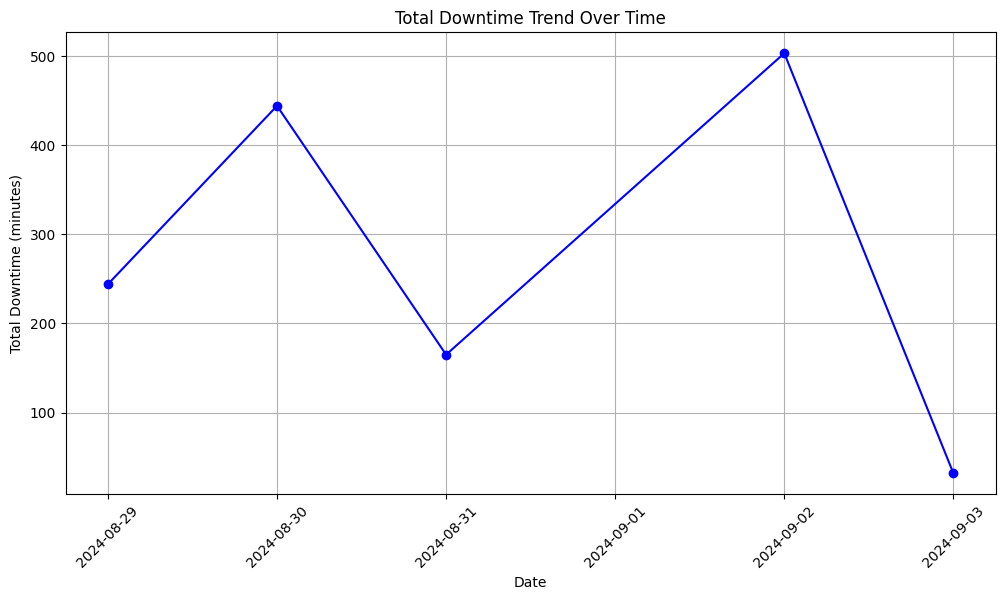

In [ ]:
#downtime trends over time
import matplotlib.pyplot as plt


# Group by Date and sum the total downtime for trend analysis
downtime_trend = productivity_df.groupby("Date")["Total Downtime"].sum()

# Plot the downtime trend over time
plt.figure(figsize=(12, 6))
plt.plot(downtime_trend.index, downtime_trend.values, marker="o", linestyle="-", color="b")
plt.title("Total Downtime Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Downtime (minutes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
#Mean Absolute Error (MAE)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Selecting relevant features for downtime prediction
features = ["Efficiency", "Min Batch Time", "Total Downtime with Human Errors", "Total Downtime without Human Errors"]
target = "Total Downtime"

# Drop rows with missing values
productivity_df = productivity_df.dropna(subset=features + [target])


X = productivity_df[features]
y = productivity_df[target]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mae


10.04375

In [ ]:
#Predicted Downtime for the Next Day
import numpy as np

# Select the last available day's data as input for prediction
latest_data = X.iloc[-1].values.reshape(1, -1)

# Predict downtime for the next day
predicted_downtime = model.predict(latest_data)[0]
predicted_downtime


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(27.6)

In [ ]:
#estimated number of batches that can be produced, considering shift duration and batch processing time.
# Assume an 8-hour shift (480 minutes)
shift_duration = 480

# Get the average batch processing time from the dataset
avg_batch_time = productivity_df["Min Batch Time"].mean()

# Calculate the number of batches that can be produced
batches_produced = (shift_duration - predicted_downtime) / avg_batch_time
batches_produced


np.float64(6.96)

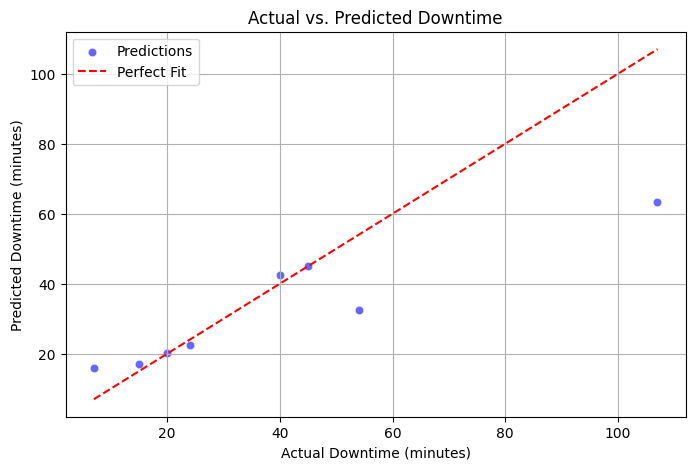

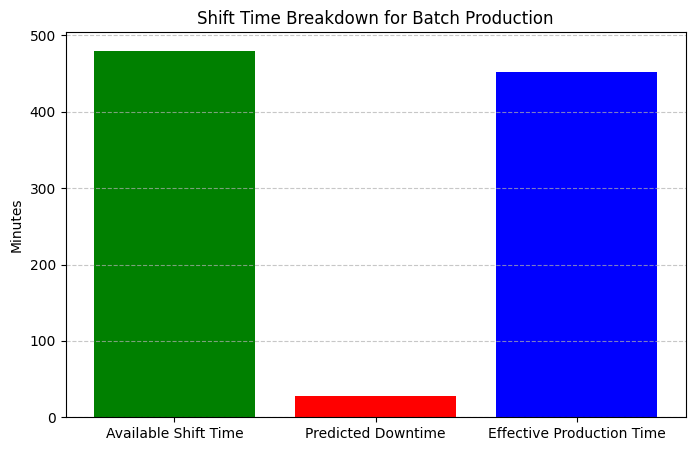

In [ ]:
import seaborn as sns

# Visualization: Actual vs Predicted Downtime
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual Downtime (minutes)")
plt.ylabel("Predicted Downtime (minutes)")
plt.title("Actual vs. Predicted Downtime")
plt.legend()
plt.grid(True)
plt.show()

# Visualization: Estimated Batch Production vs. Available Time
plt.figure(figsize=(8, 5))
categories = ["Available Shift Time", "Predicted Downtime", "Effective Production Time"]
values = [shift_duration, predicted_downtime, shift_duration - predicted_downtime]
colors = ["green", "red", "blue"]

plt.bar(categories, values, color=colors)
plt.ylabel("Minutes")
plt.title("Shift Time Breakdown for Batch Production")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
# Predict downtime for the next 7 days using the last available data point repeatedly

future_downtime = []
latest_input = latest_data  # Start with the last available day's features

for _ in range(7):
    pred_downtime = model.predict(latest_input)[0]  # Predict downtime
    future_downtime.append(pred_downtime)
    latest_input = np.array(latest_input).reshape(1, -1)  # Keep using the same input for simplicity

# Create a date range for the next 7 days
future_dates = pd.date_range(start=productivity_df["Date"].max() + pd.Timedelta(days=1), periods=7)

# Convert results into a DataFrame
future_downtime_df = pd.DataFrame({"Date": future_dates, "Predicted Downtime": future_downtime})

# Display the predicted downtime for the next 7 days
future_downtime_df


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

,Date,Predicted Downtime
0,2024-09-04,27.6
1,2024-09-05,27.6
2,2024-09-06,27.6
3,2024-09-07,27.6
4,2024-09-08,27.6
5,2024-09-09,27.6
6,2024-09-10,27.6


<ipython-input-10-f01b7681cefc>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


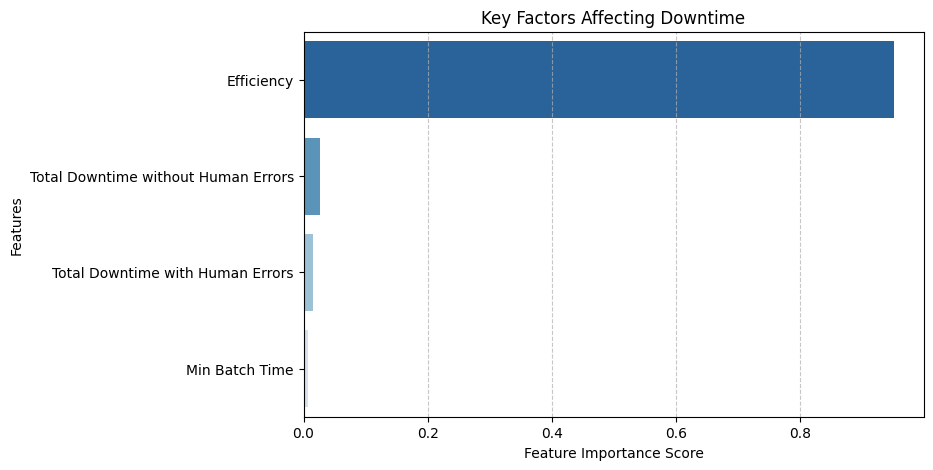

,Feature,Importance
0,Efficiency,0.951195
3,Total Downtime without Human Errors,0.026348
2,Total Downtime with Human Errors,0.016031
1,Min Batch Time,0.006425


In [ ]:
# Get feature importance from the trained model
feature_importance = model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Key Factors Affecting Downtime")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Display top features affecting downtime
importance_df
